In [1]:
%%capture
!pip install rasterio -q

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

In [3]:
# import zipfile
# import os

# # define the path to your zipped folder in /uploads
# zip_file_path = "/teamspace/uploads/S2Images.zip"

# # define the directory where you want to extract the contents
# # i'm putting it in your home directory here for easy access, but you can change this!
# extract_dir = os.path.expanduser("~/S2Images_extracted")

# # create the extraction directory if it doesn't exist
# os.makedirs(extract_dir, exist_ok=True)

# try:
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_dir)
#     print(f"successfully unzipped '{zip_file_path}' to '{extract_dir}'")
# except FileNotFoundError:
#     print(f"error: the file '{zip_file_path}' was not found.")
# except zipfile.BadZipFile:
#     print(f"error: '{zip_file_path}' is not a valid zip file.")
# except Exception as e:
#     print(f"an error occurred: {e}")

# # you can verify the contents by listing them
# print(f"\ncontents of '{extract_dir}':")
# try:
#     for item in os.listdir(extract_dir):
#         print(item)
# except FileNotFoundError:
#     print("extraction directory not found or empty.")

In [4]:
DATA_PATH = Path("")
TRAIN_IMAGES_PATH = DATA_PATH / "S2Images/S2Images/train/"
TEST_IMAGES_PATH = DATA_PATH / "S2Images/S2Images/test/"
TRAIN_CSV_PATH = "TrainDataset.csv"
TEST_CSV_PATH = "TestDataset.csv"
subPath = "submission.csv"

In [5]:
## Utility function - count the number of files in a folder:

def count_all_files(folder_path):
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

In [6]:
folder_path = TRAIN_IMAGES_PATH
total_files = count_all_files(folder_path)

print(f"📁 Total number of images from GEE in '{folder_path}': {total_files}")

📁 Total number of images from GEE in 'S2Images/S2Images/train': 7433


In [7]:
folder_path = TEST_IMAGES_PATH
total_files = count_all_files(folder_path)

print(f"📁 Total number of images from GEE in '{folder_path}': {total_files}")

📁 Total number of images from GEE in 'S2Images/S2Images/test': 2201


In [8]:
import rasterio

def get_min_max_tile_size(tif_paths):
    """
    Calculate both the minimum and maximum tile sizes (height × width) from a list of .tif file paths.

    Parameters:
    - tif_paths (list of str or Path): List of paths to .tif files

    Returns:
    - min_result (tuple): (min_size, shape, file_path, index)
    - max_result (tuple): (max_size, shape, file_path, index)
    """
    min_size = float('inf')
    max_size = 0
    min_shape = max_shape = (0, 0)
    min_file = max_file = None
    min_idx = max_idx = None

    for idx, path in enumerate(tif_paths):
        with rasterio.open(path) as src:
            height, width = src.height, src.width
            size = height * width

            if size < min_size:
                min_size = size
                min_shape = (height, width)
                min_file = path
                min_idx = idx

            if size > max_size:
                max_size = size
                max_shape = (height, width)
                max_file = path
                max_idx = idx

    min_result = (min_size, min_shape, str(min_file), min_idx)
    max_result = (max_size, max_shape, str(max_file), max_idx)
    return min_result, max_result

In [9]:
## Load the train/test csv files
train = pd.read_csv(TRAIN_CSV_PATH)
test = pd.read_csv(TEST_CSV_PATH)

train = train[train['tifPath'].notna()].copy()
print(len(train))


7433


In [10]:
def convert_path(old_path):
    filename = old_path.split("/")[-1]
    if "train" in old_path.lower():
        return f"S2Images/S2Images/train/{filename}"
    else:
        return f"S2Images/S2Images/test/{filename}"

# Apply safely
train['tifPath'] = train['tifPath'].apply(convert_path)

In [11]:
# train_tiffs = [Path(tifPath) for tifPath in train.tifPath.values if str(tifPath).endswith(".tif")]

# # Get min/max tile size of train
# min_train_results, max_train_results = get_min_max_tile_size(train_tiffs)

In [12]:
# # Overall max_tile_size
# max_tile_height = max_train_results[1][0]
# max_tile_width = max_train_results[1][1]

# # Assume a square tile
# MAX_TILE_SIZE = max(max_tile_height, max_tile_width)

# max_train_idx = max_train_results[3]

# min_train_idx = min_train_results[3]

# max_train_tif_shape = max_train_results[1]

# min_train_tif_shape = min_train_results[1]

# max_train_tif_file = max_train_results[2]
# min_train_tif_file = min_train_results[2]

In [13]:
# print(f"The maximum tile size for train is at {max_train_idx} with: (height x width) = {max_train_tif_shape}.")
# print(f"The raster image from train with maximum dimension is:\n\t{max_train_tif_file}.\n")
# print(f"The minimum tile size for train is at {min_train_idx}: (height x width) = {min_train_tif_shape}.")
# print(f"The raster image from train with the minimum dimension is:\n\t{min_train_tif_file}.\n")

# print(f"\nThe maximum tile size to use: MAX_TILE_SIZE = {(MAX_TILE_SIZE, MAX_TILE_SIZE)}.")

In [14]:
TILE_SIZE = 51

from pathlib import Path
import torch
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm

def center_crop_tensor(tensor, size=(TILE_SIZE, TILE_SIZE)):
    _, h, w = tensor.shape
    crop_h, crop_w = size
    start_h = (h - crop_h) // 2
    start_w = (w - crop_w) // 2
    return tensor[:, start_h:start_h + crop_h, start_w:start_w + crop_w]

def normalize_per_band(tensor):
    for c in range(tensor.shape[0]):
        band = tensor[c]
        min_val = band.min()
        max_val = band.max()
        tensor[c] = (band - min_val) / (max_val - min_val + 1e-5)
    return tensor

def preprocess_center_crop_and_save(df, output_dir="PreprocessedCenterCrop"):
    Path(output_dir).mkdir(exist_ok=True)
    new_rows = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        tif_path = row['tifPath']
        label = row['class']  # assumes already in 0, 1, 2
        img_out_path = Path(output_dir) / f"{Path(tif_path).stem}_img.pt"

        if img_out_path.exists():
            new_rows.append({
                "image_path": str(img_out_path),
                "label": label
            })
            continue

        try:
            with rasterio.open(tif_path) as src:
                raster = src.read()  # (C, H, W)

            tensor = torch.tensor(raster, dtype=torch.float32)
            cropped = center_crop_tensor(tensor, size=(TILE_SIZE, TILE_SIZE))
            cropped = normalize_per_band(cropped)  # ✅ normalize each band independently

            # print(f"{tif_path} stats -> min: {cropped.min().item()}, max: {cropped.max().item()}, mean: {cropped.mean().item()}")

            torch.save(cropped, img_out_path)

            new_rows.append({
                "image_path": str(img_out_path),
                "label": label
            })

        except Exception as e:
            print(f"⚠️ Failed to process {tif_path}: {e}")
            continue

    return pd.DataFrame(new_rows)

In [15]:
processed_df = preprocess_center_crop_and_save(train)

100%|██████████| 7433/7433 [00:00<00:00, 14940.78it/s]


In [16]:
processed_df.head()

,image_path,label
0,PreprocessedCenterCrop/s2_Rubber_ID_h14T0B_202...,3
1,PreprocessedCenterCrop/s2_Rubber_ID_KbyKOr_202...,3
2,PreprocessedCenterCrop/s2_Rubber_ID_t4Tmmn_202...,3
3,PreprocessedCenterCrop/s2_Rubber_ID_yipWoC_202...,3
4,PreprocessedCenterCrop/s2_Rubber_ID_XKiksa_202...,3


In [17]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% val
train_df, val_df = train_test_split(processed_df, test_size=0.2, stratify=train["Target"], random_state=42)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
train_df.head()

Train size: 5946
Val size: 1487


,image_path,label
2860,PreprocessedCenterCrop/s2_Rubber_ID_KbyKOr_202...,3
4585,PreprocessedCenterCrop/s2_Rubber_ID_KCnzD5_202...,3
822,PreprocessedCenterCrop/s2_Rubber_ID_iY4bvo_202...,3
6157,PreprocessedCenterCrop/s2_Palm_ID_VxNkXs_2024_...,2
3252,PreprocessedCenterCrop/s2_Palm_ID_SWKK78_2024_...,2


In [18]:
import torch

In [19]:
from torch.utils.data import Dataset

class CachedSegmentationDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_tensor = torch.load(self.df.iloc[idx]["image_path"], weights_only=True)
        label = self.df.iloc[idx]["label"] - 1  # class int: 0, 1, or 2
        return img_tensor, label

In [20]:
train_dataset = CachedSegmentationDataset(train_df)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)

val_dataset = CachedSegmentationDataset(val_df)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)

In [21]:
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50


class DeepLabClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        model = deeplabv3_resnet50(pretrained=True)

        # Replace the input conv layer to accept 12 channels
        old_conv = model.backbone.conv1
        model.backbone.conv1 = nn.Conv2d(
            12, old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias is not None
        )

        # Initialize the new conv weights (e.g., repeat or average across RGB)
        with torch.no_grad():
            model.backbone.conv1.weight[:, :3] = old_conv.weight  # Copy RGB
            for i in range(3, 12):
                model.backbone.conv1.weight[:, i] = old_conv.weight[:, i % 3]

        # Replace the classifier head to output class logits
        self.backbone = model.backbone
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)['out']  # Extract features
        return self.classifier(x)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [23]:
model = DeepLabClassifier(num_classes=3)
model = model.to(device)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# import os
# import shutil

# folder_name = "checkpoints"

# # remove the folder if it exists
# if os.path.exists(folder_name):
#     print(f"removing existing folder: {folder_name}")
#     shutil.rmtree(folder_name)
#     print(f"folder '{folder_name}' removed.")
# else:
#     print(f"folder '{folder_name}' does not exist, skipping removal.")

# # create the folder
# print(f"creating new folder: {folder_name}")
# os.makedirs(folder_name, exist_ok=True)
# print(f"folder '{folder_name}' created.")

In [25]:
from collections import Counter
import numpy as np
num_classes = 3
# Count occurrences of each class in the training dataset
class_counts = np.zeros(num_classes)
for _, y in train_loader:
    for label in y:
        class_counts[label.item()] += 1

# Compute weights: inverse of frequency (more weight to rare classes)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.sum()  # Normalize
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [26]:

# import os
# import shutil

# folder_name = "checkpoints"

# # remove the folder if it exists
# if os.path.exists(folder_name):
#     print(f"removing existing folder: {folder_name}")
#     shutil.rmtree(folder_name)
#     print(f"folder '{folder_name}' removed.")
# else:
#     print(f"folder '{folder_name}' does not exist, skipping removal.")

# # create the folder
# print(f"creating new folder: {folder_name}")
# os.makedirs(folder_name, exist_ok=True)
# print(f"folder '{folder_name}' created.")

import numpy as np
import torch
import torch.nn.functional as F
from torch.amp import autocast
from torch.amp import GradScaler
from tqdm import tqdm

  # [Cocoa, Palm, Rubber]
reverse_label_map = { 0: 'Cocoa', 1: 'Palm', 2: 'Rubber'}
best_val_acc = 0.0

scaler = GradScaler()
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

metrics = {
    'Loss': [],
    'Train Accuracy': [],
    'Validation Accuracy': {
        'Cocoa': [], 'Palm': [], 'Rubber': [], 'Total': []
    },
    'Validation Loss': {
        'Cocoa': [], 'Palm': [], 'Rubber': [], 'Total': []
    }
}

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0, 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast(device_type="cuda", enabled=False):
            out = model(x)

            if torch.isnan(out).any() or torch.isinf(out).any():
                print("🚨 NaN or Inf in model output!")
                print("out:", out)
                print("input stats:", x.mean(), x.std())
                exit()
            loss = loss_fn(out, y)
            # loss = F.cross_entropy(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        correct += (out.argmax(dim=1) == y).sum().item()

    train_acc = correct / len(train_loader.dataset)
    print(f"\nEpoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {train_acc:.2%}")
    metrics['Loss'].append(total_loss)
    metrics['Train Accuracy'].append(train_acc)

    # ---- Validation with per-class accuracy ----
    model.eval()
    val_correct = 0
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            out = model(x_val)
            preds = out.argmax(dim=1)

            val_correct += (preds == y_val).sum().item()
            for i in range(num_classes):
                class_correct[i] += ((preds == i) & (y_val == i)).sum().item()
                class_total[i] += (y_val == i).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    print(f"Validation Accuracy: {val_acc:.2%}")
    metrics['Validation Accuracy']['Total'].append(val_acc)
    
    val_loss = F.cross_entropy(out, y_val, weight=class_weights)
    print(f"Validation Loss: {val_loss:.2%}")
    metrics['Validation Loss']['Total'].append(val_loss)

    scheduler.step(val_loss)
    
    for i in range(num_classes):
        label = reverse_label_map[i]
        if class_total[i] > 0:
            acc_i = class_correct[i] / class_total[i]
            print(f"{label} Accuracy: {acc_i:.2%} ({int(class_correct[i])}/{int(class_total[i])})")
            metrics['Validation Accuracy'][label].append(acc_i)
        else:
            print(f"{label} Accuracy: N/A (no samples)")
            metrics['Validation Accuracy'][label].append(0.0)

    # ---- Save checkpoints ----
    torch.save(model.state_dict(), "checkpoints/last_checkpoint.pth")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "checkpoints/best_checkpoint.pth")
        print("✅ Saved new best checkpoint.")

Epoch 1: 100%|██████████| 372/372 [00:08<00:00, 43.41it/s]


Epoch 1: Loss = 348.2016, Accuracy = 56.27%


Validation Accuracy: 62.34%
Validation Loss: 83.95%
Cocoa Accuracy: 61.90% (234/378)
Palm Accuracy: 52.73% (261/495)
Rubber Accuracy: 70.36% (432/614)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


✅ Saved new best checkpoint.


Epoch 2: 100%|██████████| 372/372 [00:07<00:00, 48.03it/s]


Epoch 2: Loss = 288.3085, Accuracy = 69.11%


Validation Accuracy: 67.59%
Validation Loss: 67.10%
Cocoa Accuracy: 67.99% (257/378)
Palm Accuracy: 61.41% (304/495)
Rubber Accuracy: 72.31% (444/614)
✅ Saved new best checkpoint.


Epoch 3: 100%|██████████| 372/372 [00:07<00:00, 48.51it/s]


Epoch 3: Loss = 243.4173, Accuracy = 78.47%


Validation Accuracy: 69.33%
Validation Loss: 81.62%
Cocoa Accuracy: 73.81% (279/378)
Palm Accuracy: 60.40% (299/495)
Rubber Accuracy: 73.78% (453/614)
✅ Saved new best checkpoint.


Epoch 4: 100%|██████████| 372/372 [00:07<00:00, 48.64it/s]


Epoch 4: Loss = 202.1861, Accuracy = 86.60%


Validation Accuracy: 69.67%
Validation Loss: 76.78%
Cocoa Accuracy: 69.84% (264/378)
Palm Accuracy: 61.82% (306/495)
Rubber Accuracy: 75.90% (466/614)
✅ Saved new best checkpoint.


Epoch 5: 100%|██████████| 372/372 [00:07<00:00, 48.48it/s]


Epoch 5: Loss = 173.2202, Accuracy = 91.04%


Validation Accuracy: 71.55%
Validation Loss: 51.14%
Cocoa Accuracy: 74.07% (280/378)
Palm Accuracy: 66.67% (330/495)
Rubber Accuracy: 73.94% (454/614)
✅ Saved new best checkpoint.


Epoch 6: 100%|██████████| 372/372 [00:07<00:00, 48.08it/s]


Epoch 6: Loss = 154.8597, Accuracy = 93.73%


Validation Accuracy: 72.49%
Validation Loss: 72.55%
Cocoa Accuracy: 75.93% (287/378)
Palm Accuracy: 74.14% (367/495)
Rubber Accuracy: 69.06% (424/614)
✅ Saved new best checkpoint.


Epoch 7: 100%|██████████| 372/372 [00:07<00:00, 48.05it/s]


Epoch 7: Loss = 143.7181, Accuracy = 95.73%


Validation Accuracy: 71.69%
Validation Loss: 49.54%
Cocoa Accuracy: 75.66% (286/378)
Palm Accuracy: 69.09% (342/495)
Rubber Accuracy: 71.34% (438/614)


Epoch 8: 100%|██████████| 372/372 [00:07<00:00, 48.26it/s]


Epoch 8: Loss = 138.7640, Accuracy = 96.12%


Validation Accuracy: 72.70%
Validation Loss: 48.72%
Cocoa Accuracy: 78.84% (298/378)
Palm Accuracy: 66.26% (328/495)
Rubber Accuracy: 74.10% (455/614)
✅ Saved new best checkpoint.


Epoch 9: 100%|██████████| 372/372 [00:07<00:00, 48.28it/s]


Epoch 9: Loss = 132.3483, Accuracy = 97.07%


Validation Accuracy: 71.55%
Validation Loss: 77.35%
Cocoa Accuracy: 77.78% (294/378)
Palm Accuracy: 62.83% (311/495)
Rubber Accuracy: 74.76% (459/614)


Epoch 10: 100%|██████████| 372/372 [00:07<00:00, 47.96it/s]


Epoch 10: Loss = 130.9203, Accuracy = 97.26%


Validation Accuracy: 70.48%
Validation Loss: 116.27%
Cocoa Accuracy: 76.72% (290/378)
Palm Accuracy: 49.90% (247/495)
Rubber Accuracy: 83.22% (511/614)


Epoch 11: 100%|██████████| 372/372 [00:07<00:00, 47.90it/s]


Epoch 11: Loss = 125.9331, Accuracy = 97.86%


Validation Accuracy: 71.62%
Validation Loss: 93.08%
Cocoa Accuracy: 74.60% (282/378)
Palm Accuracy: 69.70% (345/495)
Rubber Accuracy: 71.34% (438/614)


Epoch 12: 100%|██████████| 372/372 [00:07<00:00, 48.25it/s]


Epoch 12: Loss = 123.6124, Accuracy = 98.18%


Validation Accuracy: 71.55%
Validation Loss: 58.94%
Cocoa Accuracy: 76.72% (290/378)
Palm Accuracy: 66.26% (328/495)
Rubber Accuracy: 72.64% (446/614)


Epoch 13: 100%|██████████| 372/372 [00:07<00:00, 47.97it/s]


Epoch 13: Loss = 122.2336, Accuracy = 98.37%


Validation Accuracy: 72.09%
Validation Loss: 83.94%
Cocoa Accuracy: 78.31% (296/378)
Palm Accuracy: 63.84% (316/495)
Rubber Accuracy: 74.92% (460/614)


Epoch 14: 100%|██████████| 372/372 [00:07<00:00, 48.29it/s]


Epoch 14: Loss = 126.6448, Accuracy = 97.58%


Validation Accuracy: 72.83%
Validation Loss: 74.19%
Cocoa Accuracy: 73.28% (277/378)
Palm Accuracy: 72.93% (361/495)
Rubber Accuracy: 72.48% (445/614)
✅ Saved new best checkpoint.


Epoch 15: 100%|██████████| 372/372 [00:07<00:00, 47.14it/s]


Epoch 15: Loss = 120.7108, Accuracy = 98.74%


Validation Accuracy: 70.88%
Validation Loss: 60.78%
Cocoa Accuracy: 80.69% (305/378)
Palm Accuracy: 66.06% (327/495)
Rubber Accuracy: 68.73% (422/614)


Epoch 16: 100%|██████████| 372/372 [00:07<00:00, 47.25it/s]


Epoch 16: Loss = 122.4453, Accuracy = 98.40%


Validation Accuracy: 70.95%
Validation Loss: 83.00%
Cocoa Accuracy: 76.98% (291/378)
Palm Accuracy: 61.62% (305/495)
Rubber Accuracy: 74.76% (459/614)


Epoch 17: 100%|██████████| 372/372 [00:07<00:00, 47.84it/s]


Epoch 17: Loss = 122.4299, Accuracy = 98.23%


Validation Accuracy: 66.85%
Validation Loss: 63.12%
Cocoa Accuracy: 62.17% (235/378)
Palm Accuracy: 65.66% (325/495)
Rubber Accuracy: 70.68% (434/614)


Epoch 18: 100%|██████████| 372/372 [00:07<00:00, 48.92it/s]


Epoch 18: Loss = 123.6656, Accuracy = 98.02%


Validation Accuracy: 73.37%
Validation Loss: 8.66%
Cocoa Accuracy: 82.28% (311/378)
Palm Accuracy: 64.44% (319/495)
Rubber Accuracy: 75.08% (461/614)
✅ Saved new best checkpoint.


Epoch 19: 100%|██████████| 372/372 [00:07<00:00, 47.61it/s]


Epoch 19: Loss = 118.2230, Accuracy = 98.86%


Validation Accuracy: 72.23%
Validation Loss: 92.98%
Cocoa Accuracy: 69.05% (261/378)
Palm Accuracy: 68.69% (340/495)
Rubber Accuracy: 77.04% (473/614)


Epoch 20: 100%|██████████| 372/372 [00:08<00:00, 46.02it/s]


Epoch 20: Loss = 117.8122, Accuracy = 98.79%


Validation Accuracy: 70.61%
Validation Loss: 62.34%
Cocoa Accuracy: 68.78% (260/378)
Palm Accuracy: 67.68% (335/495)
Rubber Accuracy: 74.10% (455/614)


Epoch 21: 100%|██████████| 372/372 [00:07<00:00, 48.02it/s]


Epoch 21: Loss = 116.9788, Accuracy = 99.13%


Validation Accuracy: 72.56%
Validation Loss: 68.34%
Cocoa Accuracy: 75.66% (286/378)
Palm Accuracy: 71.31% (353/495)
Rubber Accuracy: 71.66% (440/614)


Epoch 22: 100%|██████████| 372/372 [00:07<00:00, 48.76it/s]


Epoch 22: Loss = 119.3163, Accuracy = 98.60%


Validation Accuracy: 69.74%
Validation Loss: 124.77%
Cocoa Accuracy: 76.19% (288/378)
Palm Accuracy: 43.03% (213/495)
Rubber Accuracy: 87.30% (536/614)


Epoch 23: 100%|██████████| 372/372 [00:07<00:00, 48.09it/s]


Epoch 23: Loss = 118.1423, Accuracy = 98.91%


Validation Accuracy: 74.11%
Validation Loss: 50.37%
Cocoa Accuracy: 77.51% (293/378)
Palm Accuracy: 61.82% (306/495)
Rubber Accuracy: 81.92% (503/614)
✅ Saved new best checkpoint.


Epoch 24: 100%|██████████| 372/372 [00:07<00:00, 47.18it/s]


Epoch 24: Loss = 117.3436, Accuracy = 98.94%


Validation Accuracy: 73.10%
Validation Loss: 34.93%
Cocoa Accuracy: 74.60% (282/378)
Palm Accuracy: 67.27% (333/495)
Rubber Accuracy: 76.87% (472/614)


Epoch 25: 100%|██████████| 372/372 [00:07<00:00, 48.00it/s]


Epoch 25: Loss = 115.7990, Accuracy = 99.28%


Validation Accuracy: 70.28%
Validation Loss: 100.99%
Cocoa Accuracy: 71.16% (269/378)
Palm Accuracy: 69.29% (343/495)
Rubber Accuracy: 70.52% (433/614)


Epoch 26: 100%|██████████| 372/372 [00:07<00:00, 49.47it/s]


Epoch 26: Loss = 122.6207, Accuracy = 98.25%


Validation Accuracy: 72.09%
Validation Loss: 104.97%
Cocoa Accuracy: 75.40% (285/378)
Palm Accuracy: 68.28% (338/495)
Rubber Accuracy: 73.13% (449/614)


Epoch 27: 100%|██████████| 372/372 [00:07<00:00, 48.43it/s]


Epoch 27: Loss = 118.1485, Accuracy = 98.84%


Validation Accuracy: 73.84%
Validation Loss: 71.10%
Cocoa Accuracy: 73.02% (276/378)
Palm Accuracy: 72.12% (357/495)
Rubber Accuracy: 75.73% (465/614)


Epoch 28: 100%|██████████| 372/372 [00:07<00:00, 47.75it/s]


Epoch 28: Loss = 117.6371, Accuracy = 98.89%


Validation Accuracy: 70.88%
Validation Loss: 95.03%
Cocoa Accuracy: 72.75% (275/378)
Palm Accuracy: 71.52% (354/495)
Rubber Accuracy: 69.22% (425/614)


Epoch 29: 100%|██████████| 372/372 [00:07<00:00, 47.09it/s]


Epoch 29: Loss = 114.0158, Accuracy = 99.39%


Validation Accuracy: 72.36%
Validation Loss: 92.35%
Cocoa Accuracy: 73.54% (278/378)
Palm Accuracy: 59.19% (293/495)
Rubber Accuracy: 82.25% (505/614)


Epoch 30: 100%|██████████| 372/372 [00:07<00:00, 49.69it/s]


Epoch 30: Loss = 112.4985, Accuracy = 99.65%


Validation Accuracy: 72.29%
Validation Loss: 85.47%
Cocoa Accuracy: 77.51% (293/378)
Palm Accuracy: 65.66% (325/495)
Rubber Accuracy: 74.43% (457/614)


Epoch 31: 100%|██████████| 372/372 [00:07<00:00, 46.57it/s]


Epoch 31: Loss = 113.6710, Accuracy = 99.31%


Validation Accuracy: 71.62%
Validation Loss: 83.20%
Cocoa Accuracy: 69.58% (263/378)
Palm Accuracy: 56.97% (282/495)
Rubber Accuracy: 84.69% (520/614)


Epoch 32: 100%|██████████| 372/372 [00:07<00:00, 46.75it/s]


Epoch 32: Loss = 121.9334, Accuracy = 98.23%


Validation Accuracy: 72.56%
Validation Loss: 90.91%
Cocoa Accuracy: 71.43% (270/378)
Palm Accuracy: 62.83% (311/495)
Rubber Accuracy: 81.11% (498/614)


Epoch 33: 100%|██████████| 372/372 [00:07<00:00, 47.74it/s]


Epoch 33: Loss = 118.3514, Accuracy = 98.69%


Validation Accuracy: 71.89%
Validation Loss: 117.16%
Cocoa Accuracy: 75.40% (285/378)
Palm Accuracy: 63.43% (314/495)
Rubber Accuracy: 76.55% (470/614)


Epoch 34: 100%|██████████| 372/372 [00:07<00:00, 47.71it/s]


Epoch 34: Loss = 112.7604, Accuracy = 99.56%


Validation Accuracy: 71.89%
Validation Loss: 144.89%
Cocoa Accuracy: 74.07% (280/378)
Palm Accuracy: 60.20% (298/495)
Rubber Accuracy: 79.97% (491/614)


Epoch 35: 100%|██████████| 372/372 [00:07<00:00, 48.76it/s]


Epoch 35: Loss = 111.2924, Accuracy = 99.73%


Validation Accuracy: 70.61%
Validation Loss: 91.21%
Cocoa Accuracy: 82.80% (313/378)
Palm Accuracy: 63.03% (312/495)
Rubber Accuracy: 69.22% (425/614)


Epoch 36: 100%|██████████| 372/372 [00:07<00:00, 48.31it/s]


Epoch 36: Loss = 113.2571, Accuracy = 99.50%


Validation Accuracy: 70.61%
Validation Loss: 51.44%
Cocoa Accuracy: 73.54% (278/378)
Palm Accuracy: 72.12% (357/495)
Rubber Accuracy: 67.59% (415/614)


Epoch 37: 100%|██████████| 372/372 [00:07<00:00, 47.85it/s]


Epoch 37: Loss = 121.2439, Accuracy = 98.44%


Validation Accuracy: 72.56%
Validation Loss: 51.33%
Cocoa Accuracy: 73.81% (279/378)
Palm Accuracy: 69.09% (342/495)
Rubber Accuracy: 74.59% (458/614)


Epoch 38: 100%|██████████| 372/372 [00:08<00:00, 46.49it/s]


Epoch 38: Loss = 115.5020, Accuracy = 99.13%


Validation Accuracy: 72.76%
Validation Loss: 55.43%
Cocoa Accuracy: 72.75% (275/378)
Palm Accuracy: 62.42% (309/495)
Rubber Accuracy: 81.11% (498/614)


Epoch 39: 100%|██████████| 372/372 [00:07<00:00, 48.19it/s]


Epoch 39: Loss = 114.0519, Accuracy = 99.36%


Validation Accuracy: 72.09%
Validation Loss: 89.59%
Cocoa Accuracy: 78.04% (295/378)
Palm Accuracy: 69.70% (345/495)
Rubber Accuracy: 70.36% (432/614)


Epoch 40: 100%|██████████| 372/372 [00:07<00:00, 48.51it/s]


Epoch 40: Loss = 115.6586, Accuracy = 99.02%


Validation Accuracy: 72.56%
Validation Loss: 51.52%
Cocoa Accuracy: 80.95% (306/378)
Palm Accuracy: 57.17% (283/495)
Rubber Accuracy: 79.80% (490/614)


Epoch 41: 100%|██████████| 372/372 [00:07<00:00, 46.96it/s]


Epoch 41: Loss = 116.0464, Accuracy = 99.04%


Validation Accuracy: 72.76%
Validation Loss: 92.08%
Cocoa Accuracy: 78.04% (295/378)
Palm Accuracy: 72.32% (358/495)
Rubber Accuracy: 69.87% (429/614)


Epoch 42: 100%|██████████| 372/372 [00:07<00:00, 47.00it/s]


Epoch 42: Loss = 114.1299, Accuracy = 99.36%


Validation Accuracy: 73.77%
Validation Loss: 88.70%
Cocoa Accuracy: 74.87% (283/378)
Palm Accuracy: 65.66% (325/495)
Rubber Accuracy: 79.64% (489/614)


Epoch 43: 100%|██████████| 372/372 [00:07<00:00, 47.39it/s]


Epoch 43: Loss = 116.1388, Accuracy = 99.11%


Validation Accuracy: 72.56%
Validation Loss: 104.02%
Cocoa Accuracy: 75.40% (285/378)
Palm Accuracy: 60.20% (298/495)
Rubber Accuracy: 80.78% (496/614)


Epoch 44: 100%|██████████| 372/372 [00:07<00:00, 47.82it/s]


Epoch 44: Loss = 116.0608, Accuracy = 99.02%


Validation Accuracy: 70.68%
Validation Loss: 56.71%
Cocoa Accuracy: 74.07% (280/378)
Palm Accuracy: 53.54% (265/495)
Rubber Accuracy: 82.41% (506/614)


Epoch 45: 100%|██████████| 372/372 [00:07<00:00, 47.87it/s]


Epoch 45: Loss = 112.9907, Accuracy = 99.43%


Validation Accuracy: 72.70%
Validation Loss: 50.93%
Cocoa Accuracy: 76.19% (288/378)
Palm Accuracy: 71.92% (356/495)
Rubber Accuracy: 71.17% (437/614)


Epoch 46: 100%|██████████| 372/372 [00:07<00:00, 46.81it/s]


Epoch 46: Loss = 110.3691, Accuracy = 99.85%


Validation Accuracy: 72.16%
Validation Loss: 40.11%
Cocoa Accuracy: 76.46% (289/378)
Palm Accuracy: 61.21% (303/495)
Rubber Accuracy: 78.34% (481/614)


Epoch 47: 100%|██████████| 372/372 [00:07<00:00, 46.69it/s]


Epoch 47: Loss = 110.9702, Accuracy = 99.71%


Validation Accuracy: 72.63%
Validation Loss: 81.05%
Cocoa Accuracy: 78.84% (298/378)
Palm Accuracy: 70.10% (347/495)
Rubber Accuracy: 70.85% (435/614)


Epoch 48: 100%|██████████| 372/372 [00:07<00:00, 47.82it/s]


Epoch 48: Loss = 116.9611, Accuracy = 98.91%


Validation Accuracy: 72.23%
Validation Loss: 14.65%
Cocoa Accuracy: 74.34% (281/378)
Palm Accuracy: 68.08% (337/495)
Rubber Accuracy: 74.27% (456/614)


Epoch 49: 100%|██████████| 372/372 [00:07<00:00, 49.02it/s]


Epoch 49: Loss = 115.8674, Accuracy = 98.97%


Validation Accuracy: 72.83%
Validation Loss: 73.60%
Cocoa Accuracy: 78.04% (295/378)
Palm Accuracy: 62.42% (309/495)
Rubber Accuracy: 78.01% (479/614)


Epoch 50: 100%|██████████| 372/372 [00:07<00:00, 48.03it/s]


Epoch 50: Loss = 114.2732, Accuracy = 99.31%


Validation Accuracy: 74.92%
Validation Loss: 77.11%
Cocoa Accuracy: 73.81% (279/378)
Palm Accuracy: 67.88% (336/495)
Rubber Accuracy: 81.27% (499/614)
✅ Saved new best checkpoint.


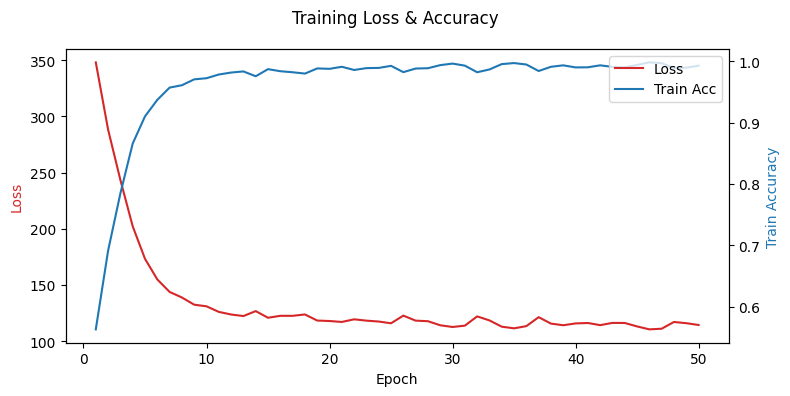

In [27]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(metrics['Loss']) + 1))

fig, ax1 = plt.subplots(figsize=(8, 4))
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, metrics['Loss'], color=color, label='Loss')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Train Accuracy', color=color)
ax2.plot(epochs, metrics['Train Accuracy'], color=color, label='Train Acc')
ax2.tick_params(axis='y')

fig.suptitle('Training Loss & Accuracy')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()

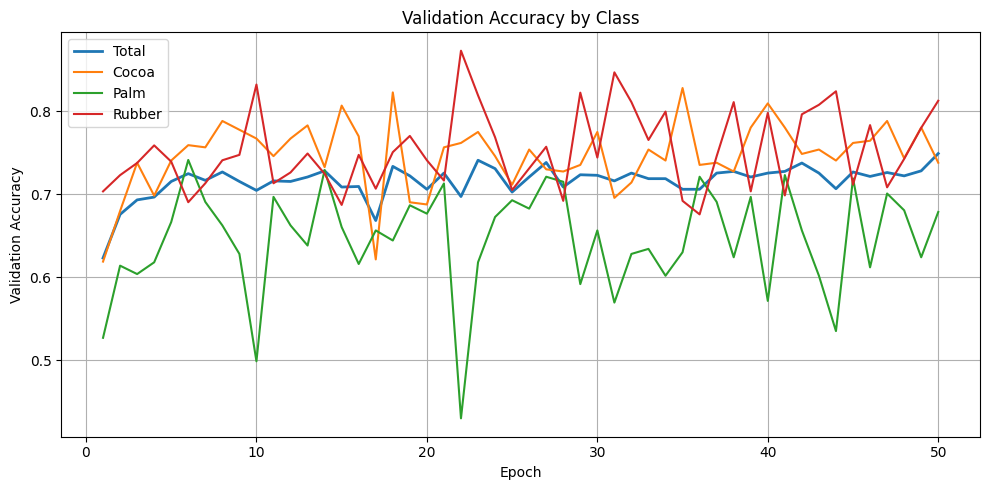

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, metrics['Validation Accuracy']['Total'], label='Total', linewidth=2)

for cls in ['Cocoa', 'Palm', 'Rubber']:
    plt.plot(epochs, metrics['Validation Accuracy'][cls], label=cls)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy by Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install plotly
model.load_state_dict(torch.load("checkpoints/best_checkpoint.pth", weights_only=True))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

import plotly.express as px
import pandas as pd

label_map = {0: "Cocoa", 1: "Palm", 2: "Rubber"}
named_preds = [label_map[p] for p in all_preds]

df = pd.DataFrame(named_preds, columns=["Prediction"])
fig = px.histogram(df, x="Prediction", color="Prediction", title="Prediction Distribution")
fig.show()